<a href="https://colab.research.google.com/github/carlsec/machine_learning/blob/master/Pytorch_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if not os.path.exists('images'):
    !pip install -qU torch_snippets
    from google.colab import files
    files.upload() # upload kaggle.json
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !ls ~/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download -d mbkinaci/fruit-images-for-object-detection
    !unzip -qq fruit-images-for-object-detection.zip
    !rm fruit-images-for-object-detection.zip

     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 204kB 8.9MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 


Saving kaggle.json to kaggle.json
kaggle.json
 32% 9.00M/28.4M [00:00<00:00, 70.2MB/s]
100% 28.4M/28.4M [00:00<00:00, 113MB/s] 


In [2]:
import albumentations as A

In [3]:
!python xml_to_csv.py -i /content/train_zip/train -o /content/train_labels.csv -l /content/train_zip/

!python xml_to_csv.py -i /content/test_zip/test -o /content/test_labels.csv

Successfully converted xml to csv.
Generate `/content/train_zip/label_map.pbtxt`
Successfully converted xml to csv.


# RUN


In [4]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

In [5]:
import pandas as pd
import numpy as np

trn_df = pd.read_csv('/content/train_labels.csv')
val_df = pd.read_csv('/content/test_labels.csv')

In [6]:
trn_df.head(10)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,banana_66.jpg,425,282,banana,20,48,333,174
1,banana_66.jpg,425,282,banana,172,67,395,282
2,banana_66.jpg,425,282,banana,57,76,349,225
3,orange_15.jpg,600,398,orange,155,99,411,329
4,orange_15.jpg,600,398,orange,24,1,239,187
5,orange_15.jpg,600,398,orange,401,47,600,297
6,orange_15.jpg,600,398,orange,205,25,417,209
7,orange_15.jpg,600,398,orange,302,272,566,398
8,apple_45.jpg,602,452,apple,34,95,359,424
9,apple_45.jpg,602,452,apple,304,62,575,353


In [7]:
trn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  465 non-null    object
 1   width     465 non-null    int64 
 2   height    465 non-null    int64 
 3   class     465 non-null    object
 4   xmin      465 non-null    int64 
 5   ymin      465 non-null    int64 
 6   xmax      465 non-null    int64 
 7   ymax      465 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 29.2+ KB


In [8]:
trn_df = trn_df[trn_df['width'] != 0].reset_index(drop=True)
val_df = val_df[val_df['width'] != 0].reset_index(drop=True)

In [9]:
trn_df.loc[0, ['xmin']]

xmin    20
Name: 0, dtype: object

In [10]:
def scaledBox(df):
  for i in range(len(df)):

    df.loc[i, 'xmin'] = df.loc[i, ['xmin']].values / df.loc[i, ['width']].values

    df.loc[i, 'ymin'] = df.loc[i, ['ymin']].values / df.loc[i, ['height']].values

    df.loc[i, 'xmax'] = df.loc[i, ['xmax']].values / df.loc[i, ['width']].values

    df.loc[i, 'ymax'] = df.loc[i, ['ymax']].values / df.loc[i, ['height']].values

  return df

In [11]:
trn_df = scaledBox(trn_df)
val_df = scaledBox(val_df)

In [12]:
trn_df.head(20)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,banana_66.jpg,425,282,banana,0.047059,0.170213,0.783529,0.617021
1,banana_66.jpg,425,282,banana,0.404706,0.237589,0.929412,1.000000
2,banana_66.jpg,425,282,banana,0.134118,0.269504,0.821176,0.797872
3,orange_15.jpg,600,398,orange,0.258333,0.248744,0.685000,0.826633
4,orange_15.jpg,600,398,orange,0.040000,0.002513,0.398333,0.469849
5,orange_15.jpg,600,398,orange,0.668333,0.118090,1.000000,0.746231
6,orange_15.jpg,600,398,orange,0.341667,0.062814,0.695000,0.525126
7,orange_15.jpg,600,398,orange,0.503333,0.683417,0.943333,1.000000
8,apple_45.jpg,602,452,apple,0.056478,0.210177,0.596346,0.938053
9,apple_45.jpg,602,452,apple,0.504983,0.137168,0.955150,0.780973


In [13]:
label2target = {l:t+1 for t,l in enumerate(val_df['class'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [14]:
num_classes

4

In [15]:
target2label

{0: 'background', 1: 'apple', 2: 'orange', 3: 'banana'}

In [26]:
from torch_snippets import *
from PIL import Image

class OpenDataset(torch.utils.data.Dataset):
    w, h = 224, 224
    def __init__(self, df, image_dir=None):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df.filename.unique()
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        data = self.df[self.df['filename'] == image_id]
        labels = data['class'].values.tolist()
        data = data[['xmin','ymin','xmax','ymax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
        # torch FRCNN expects ground truths as a dictionary of tensors
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_image(img)
        return img, target
    def collate_fn(self, batch):
        return tuple(zip(*batch)) 

    def __len__(self):
        return len(self.image_infos)

In [28]:
path_train = '/content/train_zip/train'
path_test = '/content/test_zip/test'

train_ds = OpenDataset(trn_df,path_train)
test_ds = OpenDataset(val_df,path_test)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

In [29]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [30]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
#and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [31]:
model = get_model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,
                            weight_decay=0.0005)
n_epochs = 5
log = Report(n_epochs)

In [32]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

EPOCH: 1.000	trn_loss: 0.431	trn_loc_loss: 0.188	trn_regr_loss: 0.221	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.009	val_loss: 0.285	val_loc_loss: 0.099	val_regr_loss: 0.170	val_objectness_loss: 0.009	val_rpn_box_reg_loss: 0.007	(48.12s - 192.46s remaining)
EPOCH: 2.000	trn_loss: 0.276	trn_loc_loss: 0.095	trn_regr_loss: 0.169	trn_objectness_loss: 0.006	trn_rpn_box_reg_loss: 0.007	val_loss: 0.252	val_loc_loss: 0.088	val_regr_loss: 0.153	val_objectness_loss: 0.005	val_rpn_box_reg_loss: 0.007	(97.55s - 146.33s remaining)
EPOCH: 3.000	trn_loss: 0.226	trn_loc_loss: 0.074	trn_regr_loss: 0.143	trn_objectness_loss: 0.003	trn_rpn_box_reg_loss: 0.005	val_loss: 0.249	val_loc_loss: 0.087	val_regr_loss: 0.150	val_objectness_loss: 0.005	val_rpn_box_reg_loss: 0.007	(146.41s - 97.61s remaining)
EPOCH: 4.000	trn_loss: 0.185	trn_loc_loss: 0.059	trn_regr_loss: 0.119	trn_objectness_loss: 0.003	trn_rpn_box_reg_loss: 0.005	val_loss: 0.219	val_loc_loss: 0.077	val_regr_loss: 0.130	val_objectness_loss:

100%|██████████| 106/106 [00:00<00:00, 6248.37it/s]


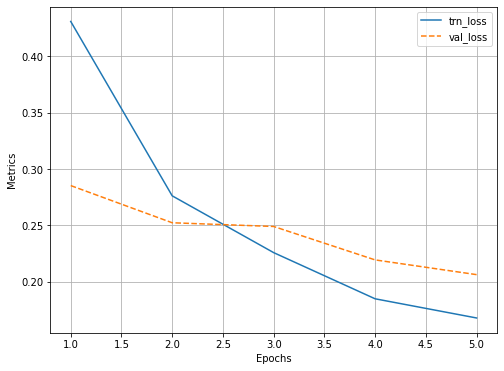

In [33]:
log.plot_epochs(['trn_loss','val_loss'])

In [34]:
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint32)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


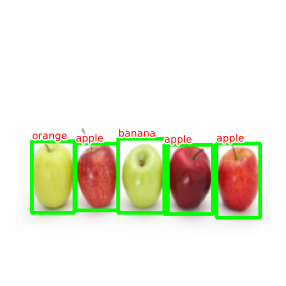

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


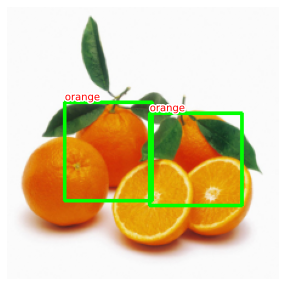

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


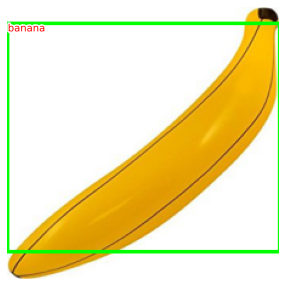

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


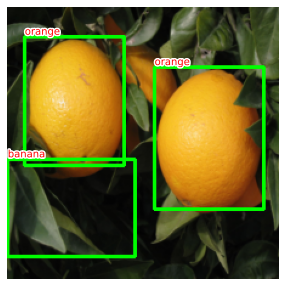

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


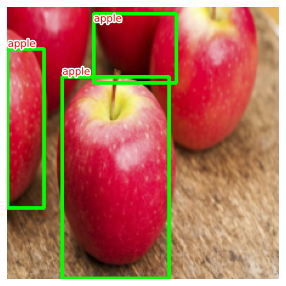

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


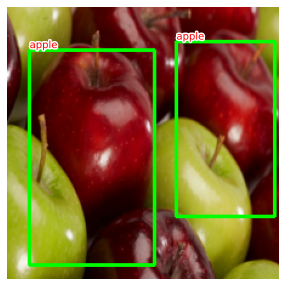

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


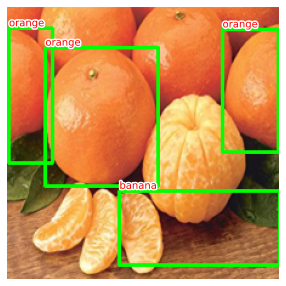

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


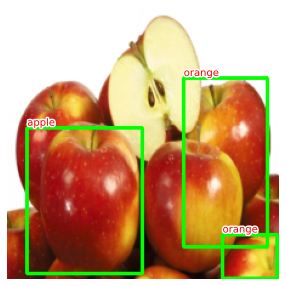

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


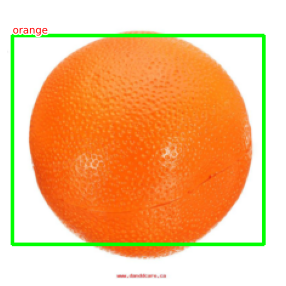

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


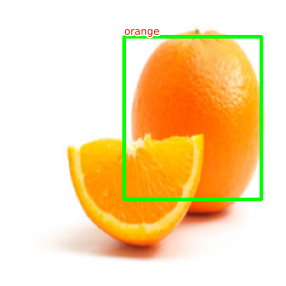

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


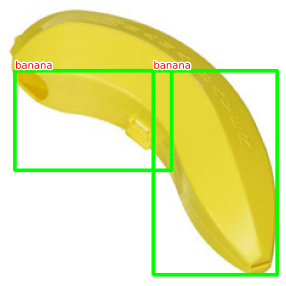

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


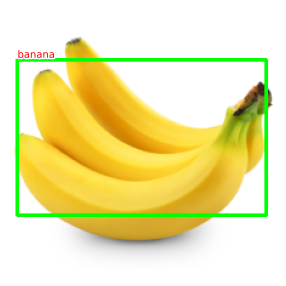

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


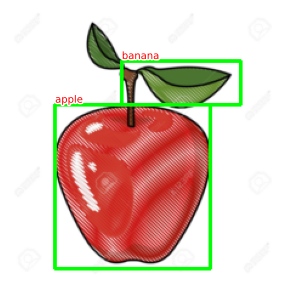

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


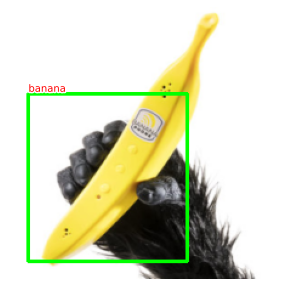

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


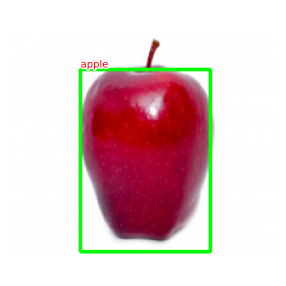

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


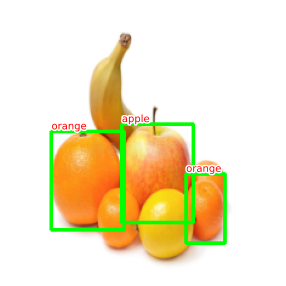

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


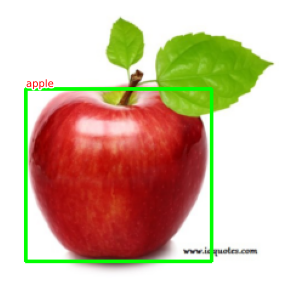

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


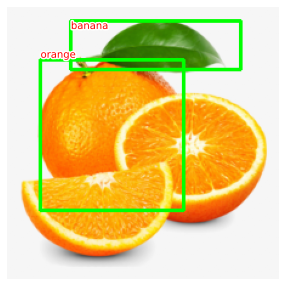

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


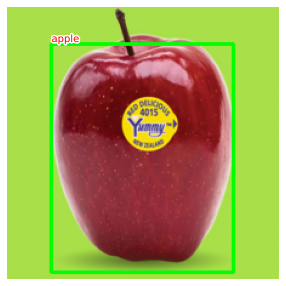

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


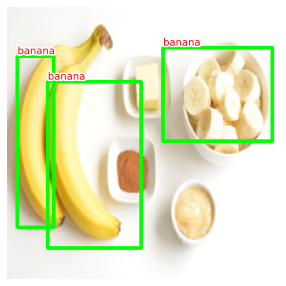

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


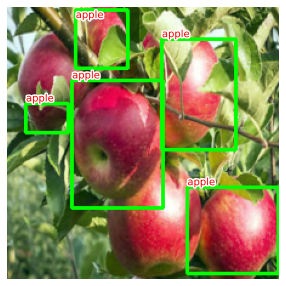

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


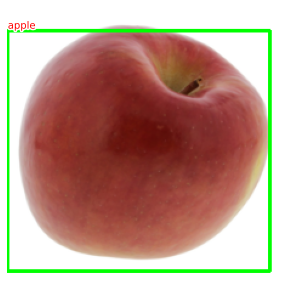

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


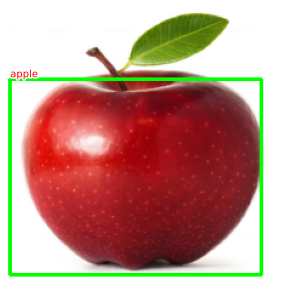

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


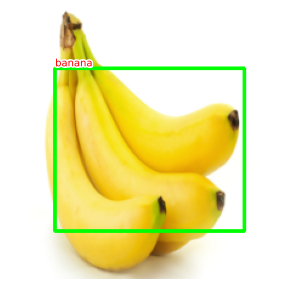

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


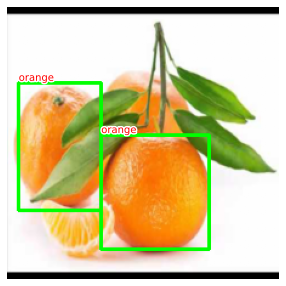

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


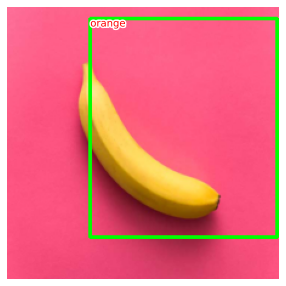

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


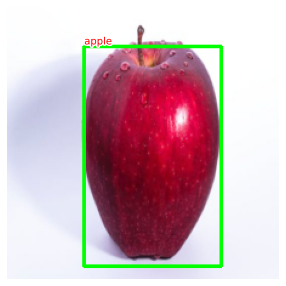

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


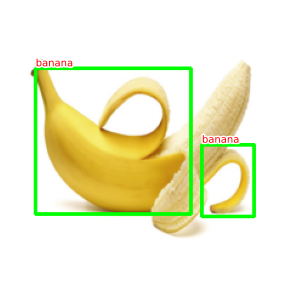

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


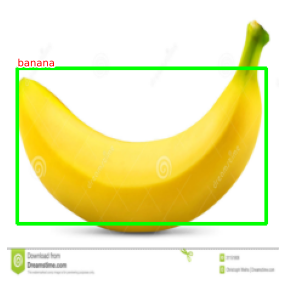

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


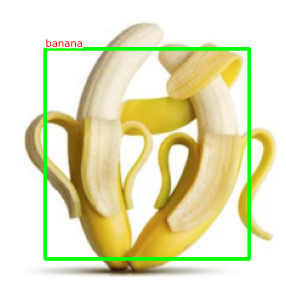

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


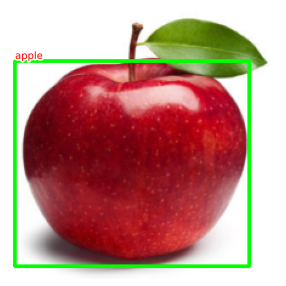

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


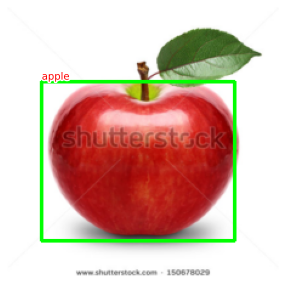

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


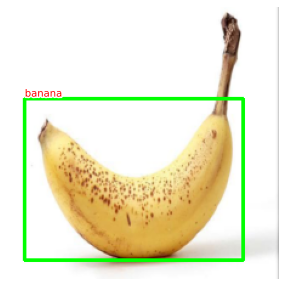

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


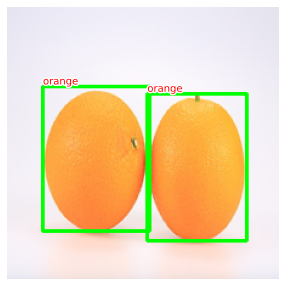

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


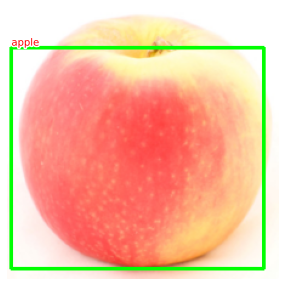

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


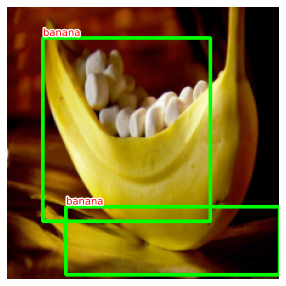

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


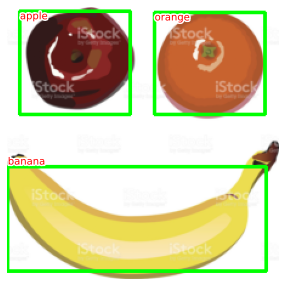

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


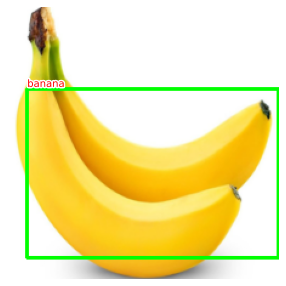

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


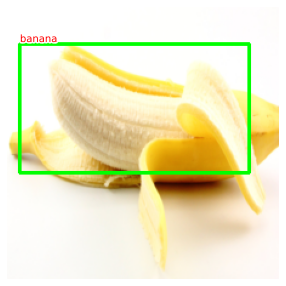

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


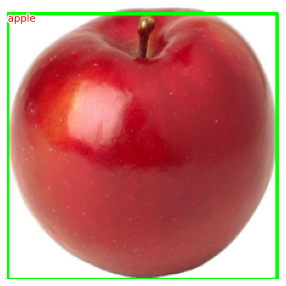

In [35]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==10: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5)